In [1]:
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import seaborn as sns
from capalyzer.packet_parser.normalize import proportions
from capalyzer.packet_parser.experimental import umap, pca_sample_cross_val
import warnings
from os.path import isfile

warnings.filterwarnings('ignore')

vir = pd.read_csv('../results/viruses.csv', index_col=1).drop('Unnamed: 0', axis=1)
bact = pd.read_csv('../results/bacteria.csv', index_col=0).drop('Unnamed: 0', axis=1)
euks = pd.read_csv('../results/eukaryota.csv', index_col=1).drop('Unnamed: 0', axis=1)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)
library(ape)

In [3]:


all_specific_amr = ['alfisols', 'andisols', 'entisols', 'gelisols', 'inceptisols', 'mollisols', 'ultisols', 'vertisols']
all_halo = ['halotolerance_classification', 'halotolerance_classification_', 'halotolerance_classification_.1', 'salinity_concentration/range(w/v)' ]


def get_filled(vir):
    msub = [col for col in vir.columns if 'metasub_' in col]
    soil = [col for col in vir.columns if 'soil_' in col or col in ['sand_rock_ice', 'soil']] 
    emp = [col for col in vir.columns if ('soil_' not in col and '___id' in col) or 'counts' in col or col in ['drylands', 'depth/altitude']]
    halo = [col for col in vir.columns if col in all_halo]
    amr = [col for col in vir.columns if col in all_specific_amr]
    vir_fill = ~vir.isna()
    vir_fill['metasub'] = vir_fill[msub].sum(axis=1)
    vir_fill = vir_fill.drop(msub, axis=1)

    vir_fill['soil'] = vir_fill[soil].sum(axis=1)
    vir_fill = vir_fill.drop(soil, axis=1)

    vir_fill['emp'] = vir_fill[emp].sum(axis=1)
    vir_fill = vir_fill.drop(emp, axis=1)
    
    vir_fill['specific_amr'] = vir_fill[amr].sum(axis=1)
    vir_fill = vir_fill.drop(amr, axis=1)
    
    vir_fill['halotolerance'] = vir_fill[halo].sum(axis=1)
    vir_fill = vir_fill.drop(halo, axis=1)

    return vir_fill.applymap(lambda el: 1 if el else 0)


def jaccard(a, b):
    c = a + b
    return sum(c == 2) / sum(c >= 1)


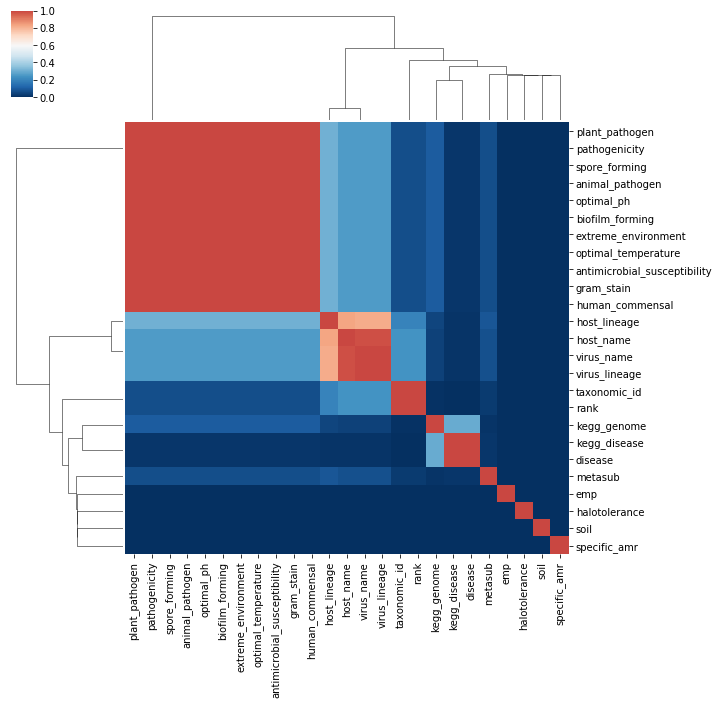

In [4]:
vir_cols = get_filled(vir).corr(method=jaccard).fillna(0)
sns.clustermap(
    vir_cols, center=0.6, cmap="RdBu_r",
    figsize=(10, 10)
)

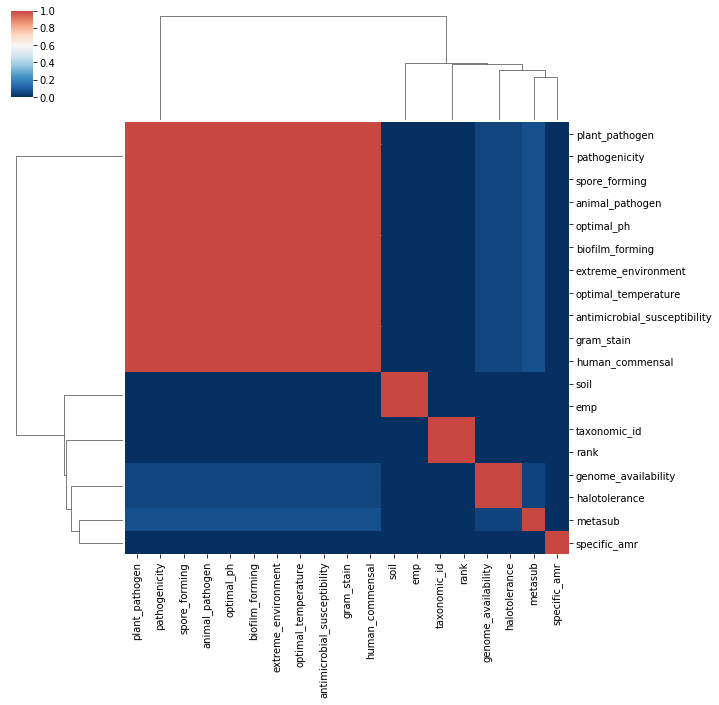

In [5]:
euk_cols = get_filled(euks).corr(method=jaccard).fillna(0)
sns.clustermap(
    euk_cols, center=0.6, cmap="RdBu_r",
    figsize=(10, 10)
)

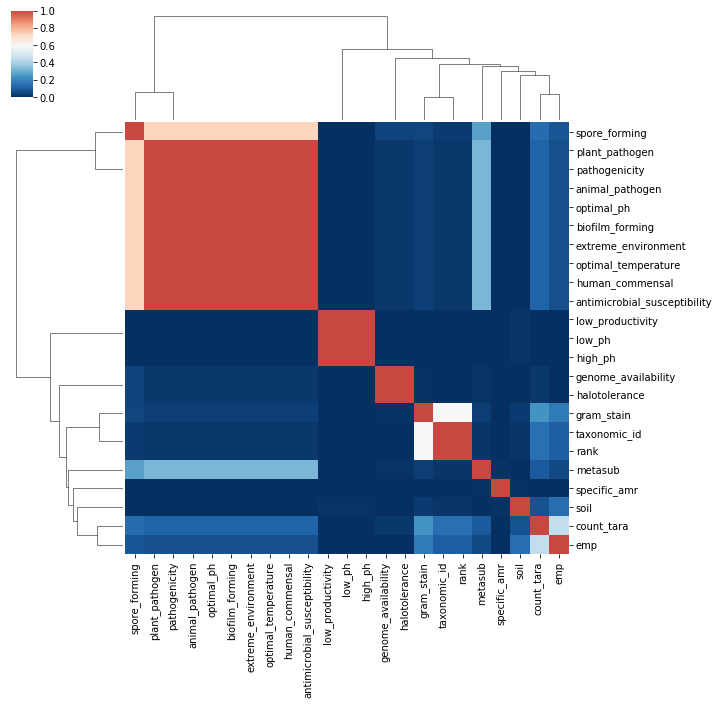

In [6]:
bac_cols = get_filled(bact).corr(method=jaccard).fillna(0)
sns.clustermap(
    bac_cols, center=0.6, cmap="RdBu_r",
    figsize=(10, 10)
)

In [7]:
((~vir.isna()).sum(axis=1) > 2).sum() + ((~euks.isna()).sum(axis=1) > 2).sum() + ((~bact.isna()).sum(axis=1) > 2).sum()

68852

In [8]:

tbl = pd.DataFrame({
    'virus': get_filled(vir).sum() / ((~vir.isna()).sum(axis=1) > 2).sum(),
    'eukaryotes': get_filled(euks).sum() / ((~euks.isna()).sum(axis=1) > 2).sum(),
    'bacteria': get_filled(bact).sum() / ((~bact.isna()).sum(axis=1) > 2).sum(),
})
tbl['feature'] = tbl.index
tbl = tbl.melt(id_vars='feature')

tbl.head()

,feature,variable,value
0,animal_pathogen,virus,0.272836
1,antimicrobial_susceptibility,virus,0.272836
2,biofilm_forming,virus,0.272836
3,count_tara,virus,NaN
4,disease,virus,0.011302


In [9]:
tbl2 = tbl
tbl2 = tbl2.query('value < 1').query('value > 0').dropna()


tbl2['feature'] = tbl2['feature'].map(lambda el: el.replace('_', ' ').strip())

for ftr in ['virus name', 'host lineage', 'virus lineage', 'low productivity', 'longitude', 'latitude', 'trophic level']:
    tbl2 = tbl2[tbl2['feature'] != ftr]
    
tbl2 = tbl2[(tbl2['feature'] != 'gram stain') + (tbl2['variable'] == 'bacteria')]
    
def titlecase(el):
    tkns = el.split()
    return ' '.join([tkn[0].upper() + tkn[1:] for tkn in tkns])
tbl2['feature'] = tbl2['feature'].map(titlecase)
tbl2['variable'] = tbl2['variable'].map(titlecase)

rmap = {
    'Kegg Genome': 'KEGG Genome',
    'Kegg Disease': 'KEGG Disease',
    'Emp': 'EMP Site',
    'Metasub': 'MetaSUB Site',
    'Low Ph': 'Low pH',
    'High Ph': 'High pH',
    'Optimal Ph': 'Optimal pH',
    'Human Microbiome Body Site': 'HMP Body Site',
    'Count Tara': 'Tara Ocean',
    'Specific Amr': 'Specific AMR',
}
tbl2['feature'] = tbl2['feature'].map(lambda el: rmap.get(el, el))

tbl2.head()

,feature,variable,value
0,Animal Pathogen,Virus,0.272836
1,Antimicrobial Susceptibility,Virus,0.272836
2,Biofilm Forming,Virus,0.272836
4,Disease,Virus,0.011302
5,EMP Site,Virus,0.000266


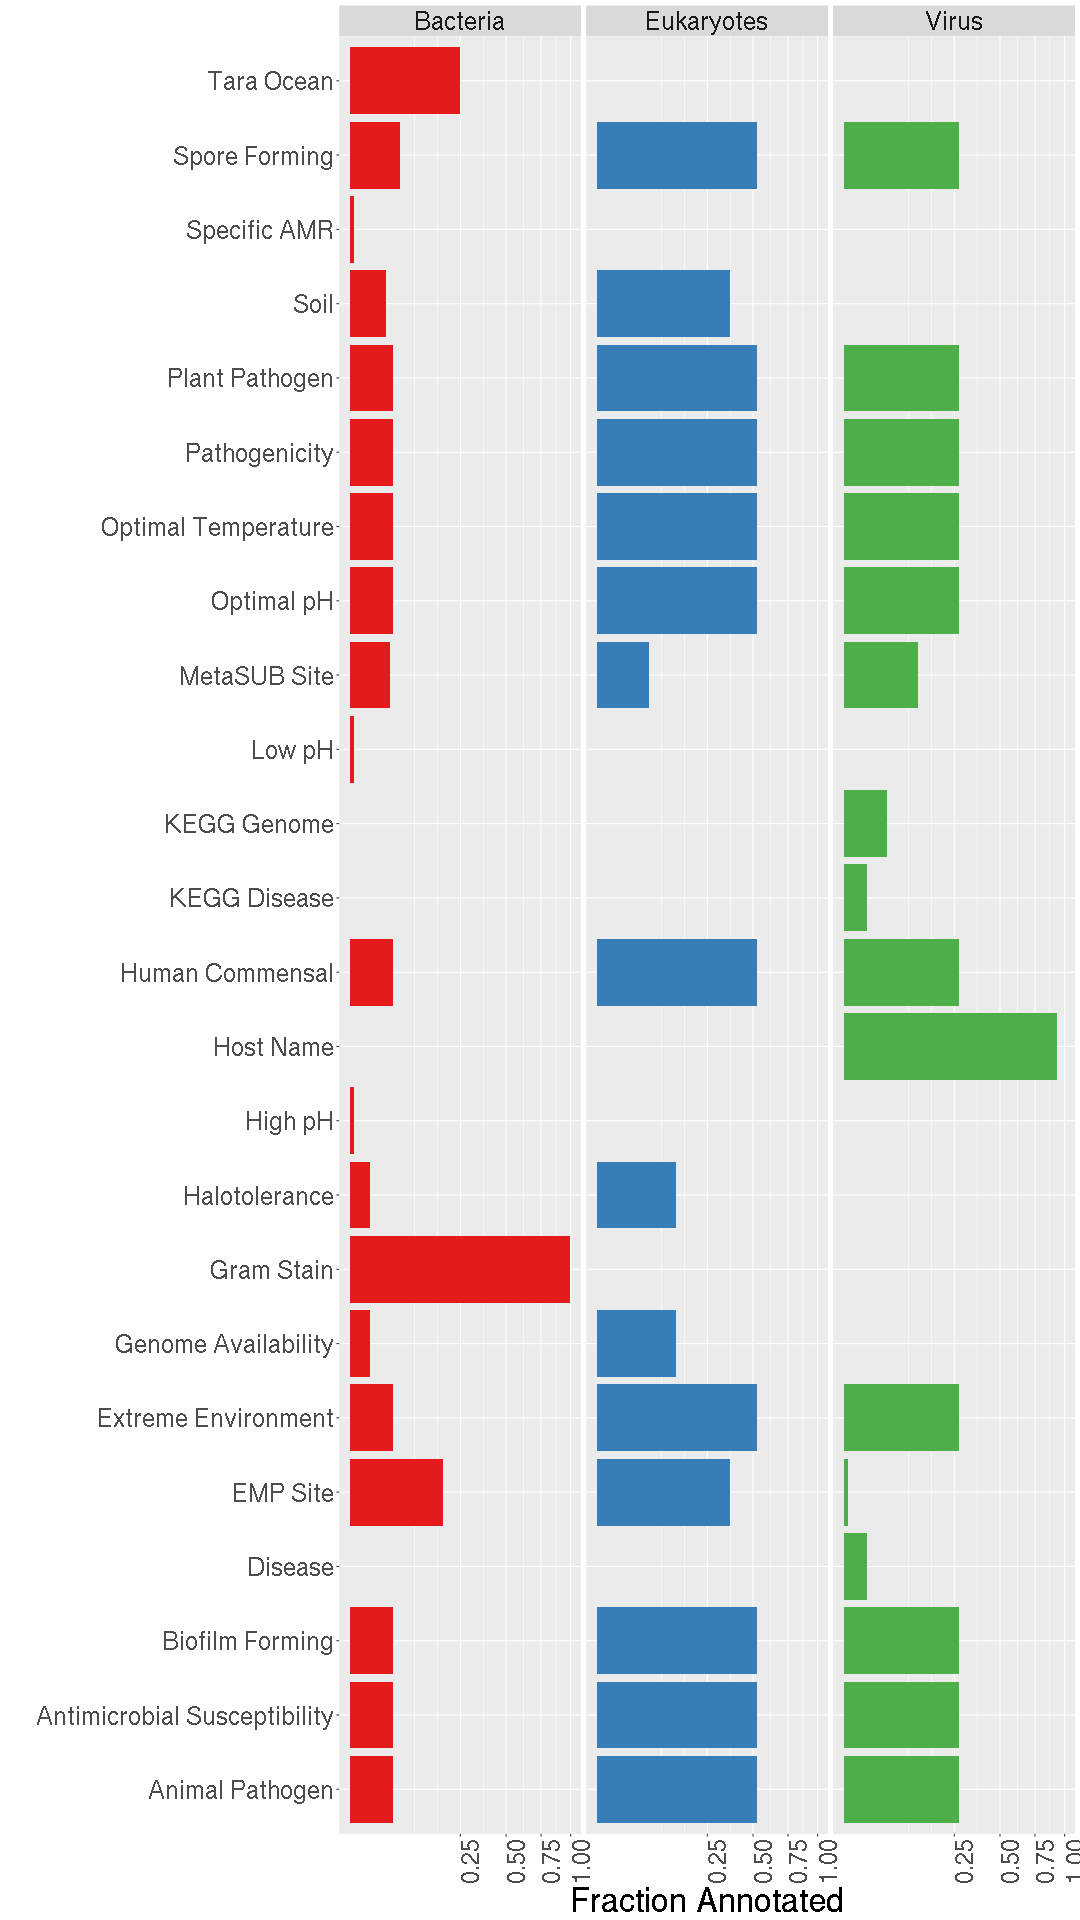

In [10]:
%%R -i tbl2 -h 1920 -w 1080

ggplot(tbl2, aes(x=feature, y=value, fill=variable)) +
    geom_col(position='dodge') +
    facet_grid(.~variable) +
    scale_fill_brewer(palette = "Set1") +
    scale_y_sqrt() +
    xlab('') + ylab('Fraction Annotated') +
    coord_flip() +
    labs(fill='Domain') +
    theme(
        text = element_text(size=30),
        axis.text.x=element_text(angle=90, hjust=1),
        legend.position='none'
    )